<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Modeling
</h1>

<h3 style="color:#555; text-align:left;">
    Algorithms, Train and Validation, hyperparametrization and model comparison
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1 Libraries and Data importation**
## **1.1 Import Libraries**

In [1]:
# --- System utilities ---
import os
import sys
import json
import joblib
from datetime import datetime

# --- Data manipulation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn base utilities ---
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

# --- Scikit-learn models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- XGBoost ---
from xgboost import XGBClassifier

# --- Optuna ---
import optuna
from optuna.trial import TrialState

c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 Import paths to files**

In [2]:
def load_all_processed_data(path: str = "../data/processed"):
    """
    Load all processed data and feature selections from the given path.
    """
    data = {}

    # ============================
    # Base data
    # ============================
    data["X"] = pd.read_parquet(f"{path}/X.parquet")
    data["X_enc"] = pd.read_parquet(f"{path}/X_enc.parquet")
    data["y"] = pd.read_csv(f"{path}/y.csv")

    # ============================
    # StratifiedKFold parameters
    # ============================
    with open(f"{path}/spkf_params.json", "r") as f:
        skf_params = json.load(f)

    data["skf"] = StratifiedKFold(
        n_splits=skf_params["n_splits"],
        shuffle=skf_params["shuffle"],
        random_state=skf_params["random_state"],
    )

    # ============================
    # Embedded methods - feature lists
    # ============================
    embedded_feature_lists = {
        "xgb_selected_features_embeded": "xgb_selected_features_embeded.json",
        "rf_selected_features_embeded": "rf_selected_features_embeded.json",
        "log_selected_features_embeded": "log_selected_features_embeded.json",
        "dt_selected_features_embeded": "dt_selected_features_embeded.json",
        "log_l1_selected_features_embeded": "log_l1_selected_features_embeded.json",
        "consensus_3of3_embeded": "consensus_3of3_embeded.json",
        "consensus_2of3_embeded": "consensus_2of3_embeded.json",
        "consensus_topN_embeded": "consensus_topN_embeded.json",
    }

    for key, filename in embedded_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Embedded methods - datasets
    #embedded_datasets = {
    #    "X_xgb_embeded": "X_xgb_embeded.parquet",
    #    "X_rf_embeded": "X_rf_embeded.parquet",
    #    "X_log_embeded": "X_log_wrapper.parquet",
    #    "X_dt_embeded": "X_dt_embeded.parquet",
    #    "X_log_l1_embeded": "X_log_l1_embeded.parquet",
    #}

    #for key, filename in embedded_datasets.items():
    #    data[key] = pd.read_parquet(f"{path}/{filename}")

    # ============================
    # Wrapper methods - feature lists
    # ============================
    wrapper_feature_lists = {
        "xgb_selected_features_wrapper": "xgb_selected_features_wrapper.json",
        "rf_selected_features_wrapper": "rf_selected_features_wrapper.json",
        "log_selected_features_wrapper": "log_selected_features_wrapper.json",
        "dt_wrap_selected_features_wrapper": "dt_wrap_selected_features_wrapper.json",
        "consensus_3of3_wrapper": "consensus_3of3_wrapper.json",
        "consensus_2of3_wrapper": "consensus_2of3_wrapper.json",
        "consensus_topN_wrapper": "consensus_topN_wrapper.json",
    }

    for key, filename in wrapper_feature_lists.items():
        with open(f"{path}/{filename}", "r") as f:
            data[key] = json.load(f)

    # Wrapper methods - datasets
    #wrapper_datasets = {
    #    "X_xgb_wrapper": "X_xgb_wrapper.parquet",
    #    "X_rf_wrapper": "X_rf_wrapper.parquet",
    #    "X_log_wrapper": "X_log_wrapper.parquet",
    #    "X_dt_wrap_wrapper": "X_dt_wrap_wrapper.parquet",
    #}

    #for key, filename in wrapper_datasets.items():
    #    data[key] = pd.read_parquet(f"{path}/{filename}")

    return data


## **1.3 Load files to dataframes**

In [3]:
# =============================================================
# Load information about Data
# =============================================================

data = load_all_processed_data()

X = data["X"]
X_enc = data["X_enc"]
y = data["y"]
y = y.squeeze()


# =============================================================
# Load information about Data Separation
# =============================================================

skf = data["skf"]

# =============================================================
# Load specific selected features datasets by Embeded Methods
# =============================================================

# Embedded – listas de features
xgb_selected_features_embeded = data["xgb_selected_features_embeded"]
rf_selected_features_embeded = data["rf_selected_features_embeded"]
log_selected_features_embeded = data["log_selected_features_embeded"]

consensus_3of3_embeded = data["consensus_3of3_embeded"]
consensus_2of3_embeded = data["consensus_2of3_embeded"]
consensus_topN_embeded = data["consensus_topN_embeded"]

# Embedded – datasets
#X_xgb_embeded = data["X_xgb_embeded"]
#X_rf_embeded = data["X_rf_embeded"]
#X_log_embeded = data["X_log_embeded"]

# =============================================================
# Load specific selected features datasets by Wrapper Methods
# =============================================================

# Wrapper – listas de features
xgb_selected_features_wrapper = data["xgb_selected_features_wrapper"]
rf_selected_features_wrapper = data["rf_selected_features_wrapper"]
log_selected_features_wrapper = data["log_selected_features_wrapper"]

consensus_3of3_wrapper = data["consensus_3of3_wrapper"]
consensus_2of3_wrapper = data["consensus_2of3_wrapper"]
consensus_topN_wrapper = data["consensus_topN_wrapper"]

# Wrapper – datasets
#X_xgb_wrapper = data["X_xgb_wrapper"]
#X_rf_wrapper = data["X_rf_wrapper"]
#X_log_wrapper = data["X_log_wrapper"]

In [4]:
import os
print(os.getcwd())

c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\notebooks


## **1.4 Creating dataframes to be tested**

In [5]:
#Subset 1: all_data
all_data_enc = pd.concat([X_enc, y], axis=1)

#Subset 2: Embedded features
df_xgb_selected_features_embeded = pd.concat([X_enc[xgb_selected_features_embeded], y], axis=1)
df_rf_selected_features_embeded = pd.concat([X_enc[rf_selected_features_embeded], y], axis=1)
df_log_selected_features_embeded = pd.concat([X_enc[log_selected_features_embeded], y], axis=1)

df_consensus_3of3_embeded = pd.concat([X_enc[consensus_3of3_embeded], y], axis=1)
df_consensus_2of3_embeded = pd.concat([X_enc[consensus_2of3_embeded], y], axis=1)
df_consensus_topN_embeded = pd.concat([X_enc[consensus_topN_embeded], y], axis=1)

#Subset 3: Wrapper features
df_xgb_selected_features_wrapper = pd.concat([X_enc[xgb_selected_features_wrapper], y], axis=1)
df_rf_selected_features_wrapper = pd.concat([X_enc[rf_selected_features_wrapper], y], axis=1)
df_log_selected_features_wrapper = pd.concat([X_enc[log_selected_features_wrapper], y], axis=1)

df_consensus_3of3_wrapper = pd.concat([X_enc[consensus_3of3_wrapper], y], axis=1)
df_consensus_2of3_wrapper = pd.concat([X_enc[consensus_2of3_wrapper], y], axis=1)
df_consensus_topN_wrapper = pd.concat([X_enc[consensus_topN_wrapper], y], axis=1)

# dictionary with all feature subsets
subsets = {
    "all_data_enc": X_enc,

    # Embedded features
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper features
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}



# **2 Model Selection**
## **2.1 Auxiliary Functions to deal with Model Selection**

### **2.1.1 Encode Data**

In [6]:
def encode_data(dataset, to_encode_cols):

    ########################################## CREATE DUMMIES #################################################
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    # 1. Criar dummies
    dummies = pd.get_dummies(dataset[to_encode_cols], drop_first=True)
    # 2. Remover colunas originais
    dataset_remaining = dataset.drop(columns=to_encode_cols)
    # 3. Juntar tudo
    final_dataset = pd.concat([dataset_remaining, dummies], axis=1)
    return final_dataset

### **2.1.2 Sub to train models**

In [7]:
def select_best_models(X_enc, y, model, skf, scale: bool=True):

    score_train, score_val = [],[]

    # perform the cross-validation
    for train_index, val_index in skf.split(X_enc,y):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if scale:
            # scale the data
            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)

        # apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

### **2.1.3 Sub to show results**

In [8]:
def show_results(df, X_enc, y, skf, models, scales):
    """
    df      : DataFrame onde vais guardar os resultados (uma linha por modelo)
    X_enc   : feature matrix já encodada
    y       : target (0/1)
    skf     : StratifiedKFold
    models  : lista de modelos [model_XGB, model_RF, model_LOG, ...]
    scales  : lista de bools [False, False, True, ...] se precisa de scaling
    """
    for i, model in enumerate(models):
        scale_flag = scales[i]
        avg_train, std_train, avg_val, std_val = select_best_models(
            X_enc, y, model, skf, scale=scale_flag
        )
        df.iloc[i] = (
            f"{avg_train} +/- {std_train}",
            f"{avg_val} +/- {std_val}"
        )
    return df


## **2.2 Model Instances**
### **2.2.1 XGBoost**

In [9]:
#calculos auxiliares para lidar com desbalanceamento
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

model_XGB = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=99,
    n_jobs=-1
)


### **2.2.2 Random Forest**

In [10]:
model_RF = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=99,
    n_jobs=-1,
    class_weight="balanced_subsample"  # ativa isto se o target estiver desequilibrado
)


### **2.2.3 Logistic Regression (with StandardScaler)**

In [11]:
model_LOG = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=99
    ))
])


## **2.3 Model Training**

In [12]:
results = {}

results["XGB"] = select_best_models(X_enc, y, model_XGB, skf, scale=False)
results["RF"] = select_best_models(X_enc, y, model_RF, skf, scale=False)
results["LOG"] = select_best_models(X_enc, y, model_LOG, skf, scale=True)


In [13]:
"Create a Dataframe with the columns ['Train', 'Validation] and the index [XGB','RF','LOG'] named as df_all."
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['XGB','RF','LOG'])

In [14]:
# =======================================
# 0. Ensure output folder exists
# =======================================

output_dir = "../data/processed/1-Initial_Model_results"
os.makedirs(output_dir, exist_ok=True)

# =======================================
# 1. Build dictionary of subsets (encoded only)
# =======================================

subsets_for_models = {
    "all_data_enc": X_enc,

    # Embedded subsets
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper subsets
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}

# =======================================
# 2. Evaluate all models on all subsets
# =======================================

models = [model_XGB, model_RF, model_LOG]
scales = [False, False, True]

all_results_list = []

for subset_name, X_sub in subsets_for_models.items():
    print(f"Running models for subset: {subset_name} (shape={X_sub.shape})")

    tmp_results = pd.DataFrame(
        index=["XGB", "RF", "LOG"],
        columns=["Train F1", "Validation (F1)"]
    )

    tmp_results = show_results(tmp_results, X_sub, y, skf, models, scales)

    tmp_results["Subset"] = subset_name
    tmp_results["Model"] = tmp_results.index

    all_results_list.append(tmp_results.reset_index(drop=True))

# =======================================
# 3. Final results table
# =======================================

final_results = pd.concat(all_results_list, ignore_index=True)
final_results = final_results[["Subset", "Model", "Train F1", "Validation (F1)"]]
final_results.set_index(["Subset", "Model"], inplace=True)

# =======================================
# 4. Timestamp
# =======================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =======================================
# 5. Save results inside folder
# =======================================

#results_csv = os.path.join(output_dir, f"final_results_{timestamp}.csv")
results_xlsx = os.path.join(output_dir, f"final_results_{timestamp}.xlsx")

#features_csv = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.csv")
features_xlsx = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.xlsx")

# Save model results
#final_results.to_csv(results_csv)
final_results.to_excel(results_xlsx)

# Save feature compositions
subset_feature_dict = {}

subset_feature_dict["all_data"] = list(X.columns)
subset_feature_dict["all_data_enc"] = list(X_enc.columns)

for name, df in subsets_for_models.items():
    subset_feature_dict[name] = list(df.columns)

subset_feature_df = (
    pd.DataFrame.from_dict(subset_feature_dict, orient="index")
    .transpose()
)

#subset_feature_df.to_csv(features_csv, index=False)
subset_feature_df.to_excel(features_xlsx, index=False)

print("Saved files:")
#print(f" - {results_csv}")
print(f" - {results_xlsx}")
#print(f" - {features_csv}")
print(f" - {features_xlsx}")
final_results


Running models for subset: all_data_enc (shape=(5634, 25))
Running models for subset: xgb_embed (shape=(5634, 15))
Running models for subset: rf_embed (shape=(5634, 15))
Running models for subset: log_embed (shape=(5634, 15))
Running models for subset: consensus_3of3_embed (shape=(5634, 25))
Running models for subset: consensus_2of3_embed (shape=(5634, 25))
Running models for subset: consensus_topN_embed (shape=(5634, 20))
Running models for subset: xgb_wrapper (shape=(5634, 23))
Running models for subset: rf_wrapper (shape=(5634, 24))
Running models for subset: log_wrapper (shape=(5634, 22))
Running models for subset: consensus_3of3_wrapper (shape=(5634, 19))
Running models for subset: consensus_2of3_wrapper (shape=(5634, 25))
Running models for subset: consensus_topN_wrapper (shape=(5634, 25))
Saved files:
 - ../data/processed/1-Initial_Model_results\final_results_20251202_021058.xlsx
 - ../data/processed/1-Initial_Model_results\subset_feature_composition_20251202_021058.xlsx


Train F1 Validation (F1)
Subset                 Model                                
all_data_enc           XGB     0.818 +/- 0.0  0.712 +/- 0.01
                       RF        1.0 +/- 0.0  0.663 +/- 0.03
                       LOG    0.673 +/- 0.01  0.669 +/- 0.01
xgb_embed              XGB     0.806 +/- 0.0   0.71 +/- 0.02
                       RF        1.0 +/- 0.0  0.659 +/- 0.03
                       LOG      0.67 +/- 0.0  0.668 +/- 0.02
rf_embed               XGB     0.813 +/- 0.0  0.707 +/- 0.02
                       RF        1.0 +/- 0.0  0.654 +/- 0.03
                       LOG      0.67 +/- 0.0  0.668 +/- 0.01
log_embed              XGB    0.716 +/- 0.01  0.674 +/- 0.01
                       RF        0.8 +/- 0.0  0.648 +/- 0.01
                       LOG    0.672 +/- 0.01   0.67 +/- 0.01
consensus_3of3_embed   XGB    0.818 +/- 0.01  0.709 +/- 0.02
                       RF        1.0 +/- 0.0  0.662 +/- 0.03
                       LOG    0.673 +/- 0.01  0.669 +/- 0.01
consensus_2of3_embed   XGB    0.818 +/- 0.01  0.709 +/- 0.02
                       RF        1.0 +/- 0.0  0.662 +/- 0.03
                       LOG    0.673 +/- 0.01  0.669 +/- 0.01
consensus_topN_embed   XGB    0.816 +/- 0.01  0.711 +/- 0.02
                       RF        1.0 +/- 0.0  0.667 +/- 0.03
                       LOG     0.673 +/- 0.0  0.671 +/- 0.01
xgb_wrapper            XGB    0.817 +/- 0.01   0.71 +/- 0.01
                       RF        1.0 +/- 0.0  0.666 +/- 0.03
                       LOG     0.673 +/- 0.0  0.668 +/- 0.01
rf_wrapper             XGB    0.819 +/- 0.01  0.712 +/- 0.01
                       RF        1.0 +/- 0.0  0.667 +/- 0.03
                       LOG     0.673 +/- 0.0  0.667 +/- 0.02
log_wrapper            XGB     0.792 +/- 0.0  0.704 +/- 0.02
                       RF        1.0 +/- 0.0  0.658 +/- 0.03
                       LOG     0.673 +/- 0.0   0.67 +/- 0.01
consensus_3of3_wrapper XGB     0.792 +/- 0.0  0.704 +/- 0.02
                       RF        1.0 +/- 0.0  0.657 +/- 0.03
                       LOG    0.672 +/- 0.01  0.671 +/- 0.01
consensus_2of3_wrapper XGB     0.82 +/- 0.01   0.71 +/- 0.01
                       RF        1.0 +/- 0.0  0.669 +/- 0.03
                       LOG    0.673 +/- 0.01  0.669 +/- 0.01
consensus_topN_wrapper XGB    0.816 +/- 0.01  0.713 +/- 0.02
                       RF        1.0 +/- 0.0  0.667 +/- 0.03
                       LOG    0.673 +/- 0.01  0.669 +/- 0.01

# **3 Model Optimization**
## **3.1 Auxiliary Functions**

In [15]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

In [16]:
# Example: choose one of your best-performing subsets
X_tune = subsets_for_models["consensus_3of3_wrapper"] 


## **3.2 XGBoost**
### **3.2.1 Grid Search**

In [17]:
# 1. Cálculo do scale_pos_weight (churn = classe positiva)
y_array = np.ravel(y)  # ensure 1D

pos = (y_array == 1).sum()   # churn
neg = (y_array == 0).sum()   # non-churn

scale_pos_weight = neg / pos
print(f"pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

#2 Função objective com train_score guardado no trial
def objective(trial):
    # Hyperparameter search space
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
    }

    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    )

    cv_results = cross_validate(
        model,
        X_enc,
        y_array,
        cv=skf,
        scoring="accuracy",
        return_train_score=True
    )

    mean_train = cv_results["train_score"].mean()
    mean_val = cv_results["test_score"].mean()

    # store train score in this trial, so we can use it later
    trial.set_user_attr("train_score", mean_train)

    # optimize based on validation score
    return mean_val

# 3. Correr o estudo Optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best CV accuracy:", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-02 02:10:58,955] A new study created in memory with name: no-name-a95fad38-84fb-4be4-a88f-c91e75f6baec


pos=1495, neg=4139, scale_pos_weight=2.77


[I 2025-12-02 02:10:59,581] Trial 0 finished with value: 0.7889603010869959 and parameters: {'max_depth': 3, 'learning_rate': 0.010948129832866952, 'subsample': 0.9101241944233218, 'colsample_bytree': 0.963475141777015, 'n_estimators': 267, 'min_child_weight': 4, 'gamma': 4.285415530265774, 'reg_lambda': 0.030183765197962707, 'reg_alpha': 0.13123624570392392}. Best is trial 0 with value: 0.7889603010869959.
[I 2025-12-02 02:11:01,309] Trial 1 finished with value: 0.8328013667433147 and parameters: {'max_depth': 5, 'learning_rate': 0.03566505117591188, 'subsample': 0.7520315448266102, 'colsample_bytree': 0.6499592102600011, 'n_estimators': 473, 'min_child_weight': 1, 'gamma': 0.10938762872881203, 'reg_lambda': 0.16319661598703927, 'reg_alpha': 0.212002126815687}. Best is trial 1 with value: 0.8328013667433147.
[I 2025-12-02 02:11:02,676] Trial 2 finished with value: 0.8177137624684594 and parameters: {'max_depth': 5, 'learning_rate': 0.013021742183220653, 'subsample': 0.9290172538173954

Best CV accuracy: 0.843629718471681
Best params: {'max_depth': 11, 'learning_rate': 0.07265305300095473, 'subsample': 0.964667952779356, 'colsample_bytree': 0.656797450611335, 'n_estimators': 488, 'min_child_weight': 2, 'gamma': 0.0937688056477537, 'reg_lambda': 0.22017804411328687, 'reg_alpha': 0.4825826389374686}


### **3.2.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/XGBoost** file name **XGBoost_Grid_Search_{timestamp}.xlsx**

In [18]:
#4. Construir a tabela tipo cv_results_ (com train + val), ordenar Guardar em Excel com timestamp
completed_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

optuna_results = pd.DataFrame([
    {
        "trial_number": t.number,
        "value": t.value,  # validation score (mean_val)
        "train_score": t.user_attrs.get("train_score", np.nan),
        **t.params,                 # unpack hyperparameters
        "state": t.state.name,
        "duration": t.duration
    }
    for t in completed_trials
])

optuna_sorted = optuna_results.sort_values("value", ascending=False)
optuna_sorted

output_dir = "../data/processed/2-XGBoost_Parametrization"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

filename = f"XGBoost_Grid_Search_{timestamp}.xlsx"
filepath = os.path.join(output_dir, filename)

optuna_sorted.to_excel(filepath, index=False)

print("Ficheiro guardado em:", filepath)

optuna_sorted  # para ver a tabela no notebook


Ficheiro guardado em: ../data/processed/2-XGBoost_Parametrization\XGBoost_Grid_Search_20251202_021143.xlsx


,trial_number,value,train_score,max_depth,learning_rate,subsample,colsample_bytree,n_estimators,min_child_weight,gamma,reg_lambda,reg_alpha,state,duration
4,4,0.843630,1.000000,11,0.072653,0.964668,0.656797,488,2,0.093769,0.220178,0.482583,COMPLETE,0 days 00:00:02.277204
13,13,0.841322,0.999512,10,0.062142,0.915280,0.505781,501,4,0.000405,0.041667,1.098051,COMPLETE,0 days 00:00:02.576256
21,21,0.841321,0.998846,10,0.056307,0.947950,0.509265,497,3,0.009524,0.015098,1.435722,COMPLETE,0 days 00:00:03.062527
14,14,0.840967,0.999956,10,0.066259,0.939055,0.500721,490,3,0.007525,0.024430,1.130204,COMPLETE,0 days 00:00:02.684354
5,5,0.839014,0.958067,12,0.017303,0.854526,0.615345,312,4,0.672770,1.220612,0.001167,COMPLETE,0 days 00:00:02.334129
12,12,0.837950,0.958467,12,0.027477,0.782892,0.817331,266,6,1.151310,0.336651,0.001049,COMPLETE,0 days 00:00:01.576178
23,23,0.837594,0.970669,10,0.053078,0.965321,0.537604,480,1,0.786550,0.001566,1.148729,COMPLETE,0 days 00:00:01.445612
22,22,0.837418,0.970980,9,0.078537,0.957527,0.617100,528,3,0.294845,0.012060,2.551940,COMPLETE,0 days 00:00:01.520836
24,24,0.837416,0.992900,11,0.142836,0.862829,0.585483,597,4,0.012688,0.090036,3.832985,COMPLETE,0 days 00:00:02.423971
20,20,0.836884,0.942625,11,0.026600,0.885061,0.726876,439,3,2.115894,0.352639,0.410267,COMPLETE,0 days 00:00:01.910982


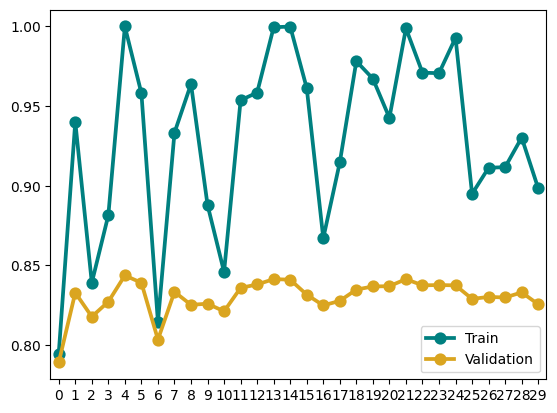

In [19]:
#6. Usar a tua point_plot com train e validation reais

validation_scores = optuna_sorted["value"].tolist()
train_scores = optuna_sorted["train_score"].tolist()
values_try = optuna_sorted["trial_number"].tolist()  # x-axis = trial index

point_plot(train_scores, validation_scores, values_try)

## **3.3 Random Forest**
### **3.3.1 Grid Search**

In [20]:
param_dist = {
    "n_estimators": [750, 1000, 1250, 1500],
    "max_depth": [5, 15, 20, 30, None],
    "max_features": ["sqrt", "log2", 0.1, 0.3, 0.5]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced_subsample"    # <<-- moved here (correct)
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,              # for a more “global” exploration
    cv=skf,                 # your existing StratifiedKFold
    scoring="accuracy",
    return_train_score=True,
    random_state=42,
    n_jobs=-1               # if you want parallelism
)

random_search.fit(X_enc, y)

best_params_rf = random_search.best_params_

### **3.3.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/RandomForest** file name **Random_Forest_Grid_Search_{timestamp}.xlsx**

In [21]:
results = pd.DataFrame(random_search.cv_results_)

# Keep only the columns we care about
cols = [
    "param_n_estimators",
    "param_max_depth",
    "param_max_features",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]
results = results[cols]

results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================

# 1. Define the directory where the file will be saved
output_dir = "../data/processed/3-RandomForest_Parametrization"

# 2. Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# 3. Create timestamp (YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 4. Build filename
filename = f"Random_Forest_Grid_Search_{timestamp}.xlsx"

# 5. Full path
filepath = os.path.join(output_dir, filename)

# 6. Save the Excel file
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")

results_sorted


Ficheiro guardado em: ../data/processed/3-RandomForest_Parametrization\Random_Forest_Grid_Search_20251202_021354.xlsx


,param_n_estimators,param_max_depth,param_max_features,mean_train_score,mean_test_score,std_test_score,rank_test_score
23,1250,20,sqrt,0.998758,0.843276,0.011389,1
26,750,20,sqrt,0.998802,0.843098,0.010331,2
0,1500,None,sqrt,1.000000,0.842744,0.011592,3
7,750,None,sqrt,1.000000,0.842389,0.013036,4
12,1000,30,0.3,1.000000,0.842389,0.010465,5
29,750,30,0.3,1.000000,0.841856,0.009607,6
3,1000,20,log2,0.998181,0.841678,0.008145,7
27,750,None,0.5,1.000000,0.841500,0.007909,8
16,750,30,0.5,1.000000,0.841323,0.007371,9
4,750,20,log2,0.998181,0.840968,0.008273,10


### **3.3.3 Visualizing the Grid Search**

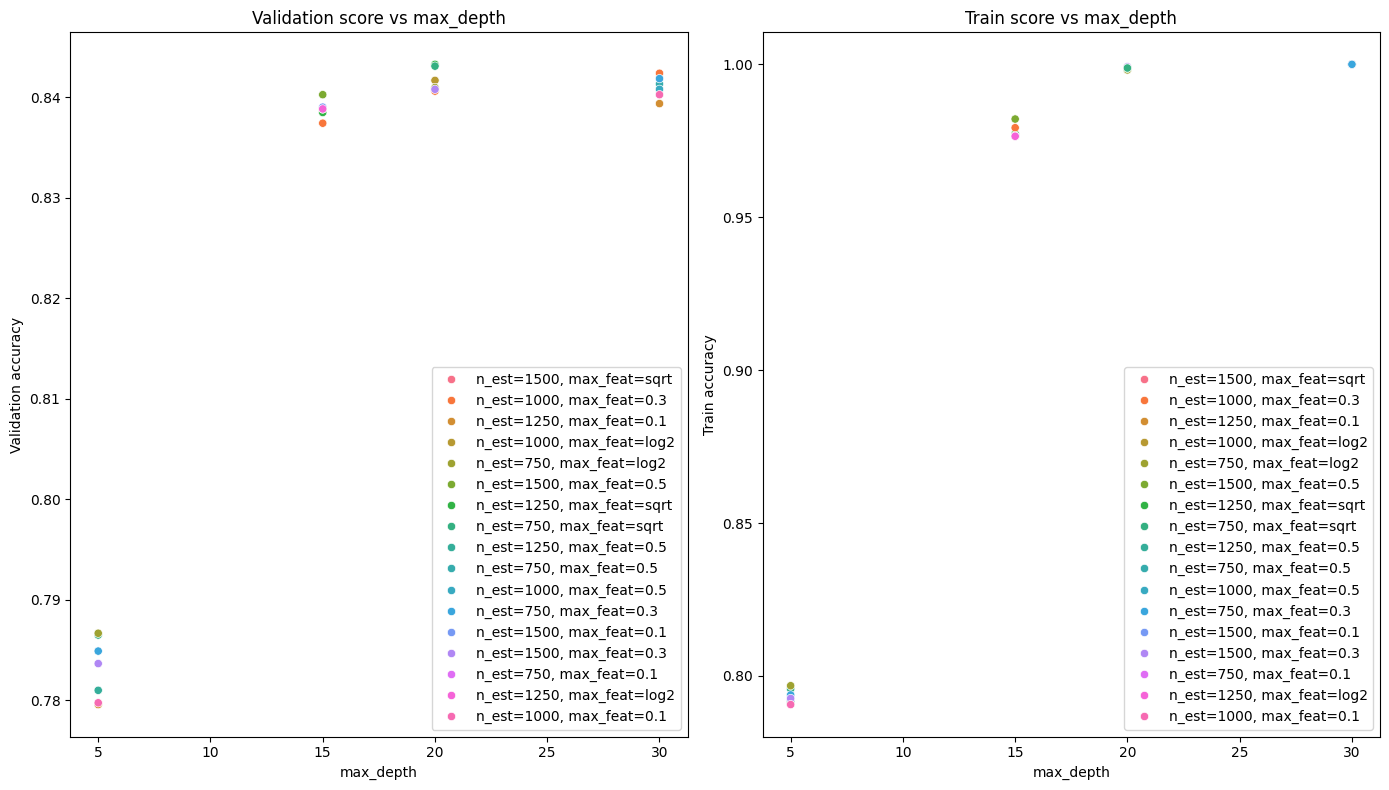

In [22]:
def combo_label(row):
    return f"n_est={row['param_n_estimators']}, max_feat={row['param_max_features']}"

results["combo"] = results.apply(combo_label, axis=1)


# results = DataFrame construído antes
# já tem as colunas: param_max_depth, mean_train_score, mean_test_score, combo

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# --- VALIDATION ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_test_score",
    hue="combo",
    ax=ax[0]
)

ax[0].set_title("Validation score vs max_depth")
ax[0].legend(loc="lower right")     # <<-- legenda do subplot 0
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("Validation accuracy")

# --- TRAIN ---
sns.scatterplot(
    data=results,
    x="param_max_depth",
    y="mean_train_score",
    hue="combo",
    ax=ax[1]
)

ax[1].set_title("Train score vs max_depth")
ax[1].legend(loc="lower right")      # <<-- legenda do subplot 1
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("Train accuracy")

plt.tight_layout()
plt.show()


## **3.4 Logistic Regression (with StandardScaler)**
### **3.4.1 Grid Search**

In [23]:
# 1. Parameter grid
param_grid = [
    {
        "penalty": ["l2"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
#    {
#        "penalty": ["l1"],
#        "solver": ["liblinear", "saga"],
#        "C": [0.001, 0.01, 0.1, 1, 10, 100],
#        "class_weight": [None, "balanced"]
#    },
#    {
#        "penalty": ["elasticnet"],
#        "solver": ["saga"],
#        "l1_ratio": [0.1, 0.5, 0.9],
#        "C": [0.001, 0.01, 0.1, 1, 10],
#        "class_weight": [None, "balanced"]
#    },
#    {
#        "penalty": ["none"],
#        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
#        "class_weight": [None, "balanced"]
#    }
]

# 2. Model
log_reg = LogisticRegression(max_iter=1000)

# 3. Grid Search using your existing skf
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=skf,                     # <<-- your StratifiedKFold
    scoring="accuracy",
    return_train_score=True
)

grid.fit(X_enc, y)

best_params_log = grid.best_params_


c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Incr

### **3.4.2 Export results to xlsx**

Please consult Grid Search on folder **.../data/processed/Logistic_Regression_Optimization** file name **Logistic_Regression_Grid_Search_{timestamp}.xlsx**

In [24]:
results = pd.DataFrame(grid.cv_results_)

cols = [
    "param_C",
    "param_penalty",
    "param_solver",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]

results = results[cols]
results_sorted = results.sort_values("mean_test_score", ascending=False)


# ==============================================
# Saving the conclusions to xlx with time stamp
# ===============================================
# 1. Output directory
output_dir = "../data/processed/4-Logistic_Regression__Parametrization"
os.makedirs(output_dir, exist_ok=True)

# 2. Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 3. Filename
filename = f"Logistic_Regression_Grid_Search_{timestamp}.xlsx"

# 4. Full path
filepath = os.path.join(output_dir, filename)

# 5. Save Excel
results_sorted.to_excel(filepath, index=False)

print(f"Ficheiro guardado em: {filepath}")


results_sorted


Ficheiro guardado em: ../data/processed/4-Logistic_Regression__Parametrization\Logistic_Regression_Grid_Search_20251202_021626.xlsx


,param_C,param_penalty,param_solver,mean_train_score,mean_test_score,std_test_score,rank_test_score
17,0.100,l2,newton-cg,0.832579,0.830320,0.011388,1
25,1.000,l2,newton-cg,0.833600,0.829965,0.010854,2
33,10.000,l2,newton-cg,0.833467,0.829787,0.010103,3
41,100.000,l2,newton-cg,0.833378,0.829609,0.009169,4
24,1.000,l2,lbfgs,0.826189,0.823576,0.014801,5
40,100.000,l2,lbfgs,0.823305,0.821800,0.011319,6
32,10.000,l2,lbfgs,0.825613,0.821090,0.012150,7
16,0.100,l2,lbfgs,0.820155,0.818605,0.013205,8
9,0.010,l2,newton-cg,0.817270,0.815588,0.012492,9
8,0.010,l2,lbfgs,0.813720,0.813814,0.015116,10


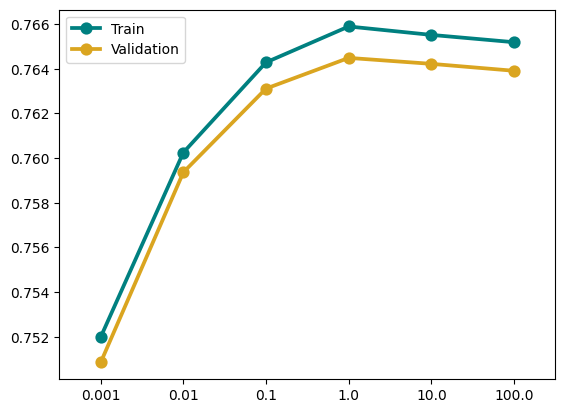

In [25]:
# 1) Put cv_results_ into a DataFrame
results = pd.DataFrame(grid.cv_results_)

# 2) Group by C and compute mean train/validation score per C
group = results.groupby("param_C").agg(
    mean_train=("mean_train_score", "mean"),
    mean_val=("mean_test_score", "mean")
).reset_index()

# 3) Prepare data for point_plot
values_try = group["param_C"].tolist()         # x-axis = C values
train_scores = group["mean_train"].tolist()    # y1 = train
validation_scores = group["mean_val"].tolist() # y2 = validation

# 4) Plot
point_plot(train_scores, validation_scores, values_try)

O C é o hiperparâmetro de regularização da Logistic Regression.

✔️ É o inverso da força de regularização.
✔️ Ou seja:

C pequeno → regularização forte → modelo mais simples

C grande → regularização fraca → modelo mais complexo

Como interpretar isto na prática?

 - Quando o dataset tem muito ruído → C pequeno é melhor

 - Quando tens muitas features → C pequeno evita overfitting

 - Quando tens dados simples bem separados → C grande dá mais precisão

 - Quando tens dados desbalanceados → C interage com class_weight e solver

In [26]:
# Criar DataFrame com resultados do GridSearch
# Put cv_results_ into a DataFrame
results = pd.DataFrame(grid.cv_results_)

# Keep only the columns we care about
plot_df = results[
    [
        "param_C",
        "param_penalty",
        "param_solver",
        "param_class_weight",
        "mean_train_score",
        "mean_test_score"
    ]
].copy()

# Sometimes param_C comes as object/string, ensure numeric
plot_df["param_C"] = plot_df["param_C"].astype(float)


In [27]:
# Melt into long format: one row per (C, penalty, solver, class_weight, dataset)
plot_long = plot_df.melt(
    id_vars=["param_C", "param_penalty", "param_solver", "param_class_weight"],
    value_vars=["mean_train_score", "mean_test_score"],
    var_name="dataset",
    value_name="score"
)

# Rename dataset labels to nicer names
plot_long["dataset"] = plot_long["dataset"].map(
    {
        "mean_train_score": "Train",
        "mean_test_score": "Validation"
    }
)


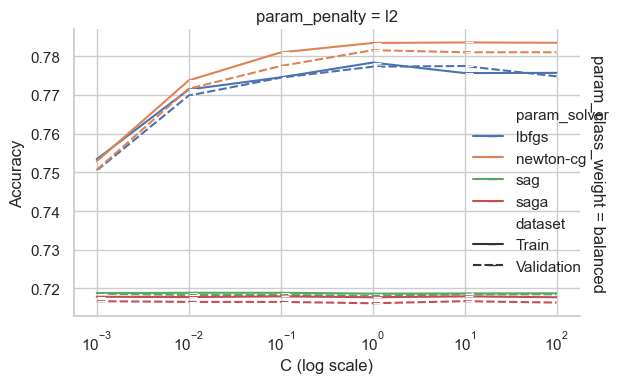

In [28]:
# Gráfico automático de overfitting (C × penalty × solver × class_weight)

sns.set(style="whitegrid")

g = sns.relplot(
    data=plot_long,
    x="param_C",
    y="score",
    hue="param_solver",
    style="dataset",          # Train vs Validation
    row="param_class_weight", # None vs balanced
    col="param_penalty",      # l1, l2, elasticnet, none
    kind="line",
    marker=True,
    facet_kws={"margin_titles": True},
    height=4,
    aspect=1.2
)

# Log scale for C and labels
for ax in g.axes.flat:
    ax.set_xscale("log")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


# **4 Final Models**
## **4.1 Best XGBoost Grid Search Parameters Model**

In [29]:
best_params = study.best_params
best_params

{'max_depth': 11,
 'learning_rate': 0.07265305300095473,
 'subsample': 0.964667952779356,
 'colsample_bytree': 0.656797450611335,
 'n_estimators': 488,
 'min_child_weight': 2,
 'gamma': 0.0937688056477537,
 'reg_lambda': 0.22017804411328687,
 'reg_alpha': 0.4825826389374686}

In [30]:
from xgboost import XGBClassifier

final_xgb = XGBClassifier(
    **best_params,                 # best hyperparameters from Optuna
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

## **4.2 Best Random Forest Grid Search Parameters Model**

In [31]:
best_params_rf

{'n_estimators': 1250, 'max_features': 'sqrt', 'max_depth': 20}

In [32]:
final_rf = RandomForestClassifier(
    **best_params_rf,
    class_weight="balanced_subsample",  # se usaste isto no modelo base
    random_state=42,
    n_jobs=-1
)

## **4.3 Best Logistic Regression Grid Search Parameters Model**

In [33]:
best_params_log

{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}

In [34]:
best_params_log = grid.best_params_

final_log_reg = LogisticRegression(
    **best_params_log,
    max_iter=1000
)

## **4.4 Select Winner Model**
### **4.4.1 Train Optimized models on subsets of features**

In [35]:
# =======================================
# 0. Ensure output folder exists
# =======================================

output_dir = "../data/processed/5-Optimized_Model_results"
os.makedirs(output_dir, exist_ok=True)

# =======================================
# 1. Build dictionary of subsets (encoded only)
# =======================================

subsets_for_models = {
    "all_data_enc": X_enc,

    # Embedded subsets
    "xgb_embed": X_enc[xgb_selected_features_embeded],
    "rf_embed": X_enc[rf_selected_features_embeded],
    "log_embed": X_enc[log_selected_features_embeded],
    "consensus_3of3_embed": X_enc[consensus_3of3_embeded],
    "consensus_2of3_embed": X_enc[consensus_2of3_embeded],
    "consensus_topN_embed": X_enc[consensus_topN_embeded],

    # Wrapper subsets
    "xgb_wrapper": X_enc[xgb_selected_features_wrapper],
    "rf_wrapper": X_enc[rf_selected_features_wrapper],
    "log_wrapper": X_enc[log_selected_features_wrapper],
    "consensus_3of3_wrapper": X_enc[consensus_3of3_wrapper],
    "consensus_2of3_wrapper": X_enc[consensus_2of3_wrapper],
    "consensus_topN_wrapper": X_enc[consensus_topN_wrapper],
}

# =======================================
# 2. Evaluate all models on all subsets
# =======================================

models = [final_xgb, final_rf, final_log_reg]
scales = [False, False, True]

Final_models_results_list = []

for subset_name, X_sub in subsets_for_models.items():
    print(f"Running models for subset: {subset_name} (shape={X_sub.shape})")

    tmp_results = pd.DataFrame(
        index=["XGB", "RF", "LOG"],
        columns=["Train F1", "Validation (F1)"]
    )

    tmp_results = show_results(tmp_results, X_sub, y, skf, models, scales)

    tmp_results["Subset"] = subset_name
    tmp_results["Model"] = tmp_results.index

    Final_models_results_list.append(tmp_results.reset_index(drop=True))

# =======================================
# 3. Final results table
# =======================================

final_models_results = pd.concat(Final_models_results_list, ignore_index=True)
final_models_results = final_models_results[["Subset", "Model", "Train F1", "Validation (F1)"]]
final_models_results.set_index(["Subset", "Model"], inplace=True)

# =======================================
# 4. Timestamp
# =======================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =======================================
# 5. Save results inside folder
# =======================================

results_xlsx = os.path.join(output_dir, f"final_results_{timestamp}.xlsx")
features_xlsx = os.path.join(output_dir, f"subset_feature_composition_{timestamp}.xlsx")

# Save model results
final_models_results.to_excel(results_xlsx)

# Save feature compositions
subset_feature_dict = {}

subset_feature_dict["all_data"] = list(X.columns)
subset_feature_dict["all_data_enc"] = list(X_enc.columns)

for name, df in subsets_for_models.items():
    subset_feature_dict[name] = list(df.columns)

subset_feature_df = (
    pd.DataFrame.from_dict(subset_feature_dict, orient="index")
    .transpose()
)

#subset_feature_df.to_csv(features_csv, index=False)
subset_feature_df.to_excel(features_xlsx, index=False)

print("Saved files:")
print(f" - {results_xlsx}")
print(f" - {features_xlsx}")
final_models_results


Running models for subset: all_data_enc (shape=(5634, 25))
Running models for subset: xgb_embed (shape=(5634, 15))
Running models for subset: rf_embed (shape=(5634, 15))
Running models for subset: log_embed (shape=(5634, 15))
Running models for subset: consensus_3of3_embed (shape=(5634, 25))
Running models for subset: consensus_2of3_embed (shape=(5634, 25))
Running models for subset: consensus_topN_embed (shape=(5634, 20))
Running models for subset: xgb_wrapper (shape=(5634, 23))
Running models for subset: rf_wrapper (shape=(5634, 24))
Running models for subset: log_wrapper (shape=(5634, 22))
Running models for subset: consensus_3of3_wrapper (shape=(5634, 19))
Running models for subset: consensus_2of3_wrapper (shape=(5634, 25))
Running models for subset: consensus_topN_wrapper (shape=(5634, 25))
Saved files:
 - ../data/processed/5-Optimized_Model_results\final_results_20251202_022309.xlsx
 - ../data/processed/5-Optimized_Model_results\subset_feature_composition_20251202_022309.xlsx


Train F1 Validation (F1)
Subset                 Model                                
all_data_enc           XGB       1.0 +/- 0.0  0.707 +/- 0.02
                       RF      0.998 +/- 0.0  0.673 +/- 0.03
                       LOG    0.667 +/- 0.01  0.664 +/- 0.03
xgb_embed              XGB     0.998 +/- 0.0  0.693 +/- 0.02
                       RF      0.992 +/- 0.0  0.666 +/- 0.03
                       LOG    0.659 +/- 0.01  0.652 +/- 0.02
rf_embed               XGB       1.0 +/- 0.0    0.7 +/- 0.02
                       RF      0.994 +/- 0.0  0.662 +/- 0.03
                       LOG    0.649 +/- 0.01  0.641 +/- 0.02
log_embed              XGB      0.77 +/- 0.0   0.67 +/- 0.01
                       RF        0.8 +/- 0.0  0.647 +/- 0.01
                       LOG     0.65 +/- 0.01  0.644 +/- 0.02
consensus_3of3_embed   XGB       1.0 +/- 0.0  0.699 +/- 0.02
                       RF      0.998 +/- 0.0  0.669 +/- 0.03
                       LOG    0.667 +/- 0.01  0.664 +/- 0.03
consensus_2of3_embed   XGB       1.0 +/- 0.0  0.699 +/- 0.02
                       RF      0.998 +/- 0.0  0.669 +/- 0.03
                       LOG    0.667 +/- 0.01  0.664 +/- 0.03
consensus_topN_embed   XGB       1.0 +/- 0.0  0.699 +/- 0.01
                       RF      0.994 +/- 0.0  0.664 +/- 0.03
                       LOG    0.668 +/- 0.01  0.663 +/- 0.03
xgb_wrapper            XGB       1.0 +/- 0.0    0.7 +/- 0.02
                       RF      0.996 +/- 0.0  0.672 +/- 0.03
                       LOG    0.666 +/- 0.01  0.661 +/- 0.03
rf_wrapper             XGB       1.0 +/- 0.0  0.704 +/- 0.02
                       RF      0.997 +/- 0.0  0.668 +/- 0.03
                       LOG    0.667 +/- 0.01  0.658 +/- 0.03
log_wrapper            XGB     0.996 +/- 0.0   0.68 +/- 0.02
                       RF      0.994 +/- 0.0  0.669 +/- 0.03
                       LOG    0.668 +/- 0.01  0.662 +/- 0.03
consensus_3of3_wrapper XGB     0.995 +/- 0.0   0.68 +/- 0.02
                       RF      0.993 +/- 0.0  0.664 +/- 0.03
                       LOG    0.664 +/- 0.01  0.657 +/- 0.03
consensus_2of3_wrapper XGB       1.0 +/- 0.0  0.703 +/- 0.02
                       RF      0.998 +/- 0.0  0.666 +/- 0.03
                       LOG    0.667 +/- 0.01  0.664 +/- 0.03
consensus_topN_wrapper XGB       1.0 +/- 0.0  0.706 +/- 0.01
                       RF      0.998 +/- 0.0   0.67 +/- 0.03
                       LOG    0.667 +/- 0.01  0.664 +/- 0.03

# **5 Export Model for future evaluation**

In [36]:
# =======================================
# 1. Guardar info mínima dos 3 modelos para o notebook de TEST
# =======================================

optimized_models_dir = "../data/processed/6-Optimized_Models_Parameters"
os.makedirs(optimized_models_dir, exist_ok=True)

# 6.1 Descobrir o melhor subset (maior Validation (F1)) por modelo
tmp = final_models_results.reset_index().copy()
# tmp tem colunas: ["Subset", "Model", "Train F1", "Validation (F1)"]

best_by_model = (
    tmp.sort_values(["Model", "Validation (F1)"], ascending=[True, False])
       .groupby("Model", as_index=False)
       .first()
)

# 6.2 Mapear nome do modelo (XGB, RF, LOG) para o respetivo objeto treinado
model_objects = {
    "XGB": final_xgb,
    "RF": final_rf,
    "LOG": final_log_reg,
}

# 6.3 Construir dicionário só com o necessário
optimized_models_info = {}

for _, row in best_by_model.iterrows():
    model_name  = row["Model"]     # "XGB", "RF" ou "LOG"
    subset_name = row["Subset"]    # ex: "xgb_embed", "rf_wrapper", etc.

    model_obj = model_objects[model_name]
    params = model_obj.get_params()   # hiperparâmetros para reinstanciar

    # Features usadas no subset vencedor
    best_features = list(subsets_for_models[subset_name].columns)

    optimized_models_info[model_name] = {
        "subset": subset_name,
        "features": best_features,
        "params": params,
    }

# 6.4 Guardar ficheiro com timestamp
opt_models_path = os.path.join(
    optimized_models_dir,
    f"optimized_models_for_test_{timestamp}.pkl"
)

joblib.dump(optimized_models_info, opt_models_path)

# 6.5 Criar/atualizar alias "current.pkl"
current_path = os.path.join(optimized_models_dir, "current.pkl")

# copiar sempre que existe um novo timestamp
import shutil
shutil.copyfile(opt_models_path, current_path)

print("Saved optimized models info (minimal):")
print(f" - {opt_models_path}")
print(f" - {current_path}  (updated alias)")

Saved optimized models info (minimal):
 - ../data/processed/6-Optimized_Models_Parameters\optimized_models_for_test_20251202_022309.pkl
 - ../data/processed/6-Optimized_Models_Parameters\current.pkl  (updated alias)


<!-- MODELO: Secção principal numerada -->
<!-- 
<h2 style="background-color:#1f77b4; color:white; padding:10px; border-radius:6px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Secção com linha colorida -->
<!-- 
<h2 style="color:#ff7f0e; border-bottom: 3px solid #ff7f0e; padding-bottom:4px;">
    X. Nome da Secção
</h2>
-->

<!-- MODELO: Subsecção -->
<!-- 
<h3 style="color:#2ca02c; margin-top:10px;">
    X.Y Nome da Subsecção
</h3>
-->

<!-- MODELO: Caixa de Nota -->
<!-- 
<div style="border-left: 5px solid #1f77b4; padding:10px; background-color:#f5f9ff; margin:15px 0;">
    <b>Nota:</b> Texto da nota.
</div>
-->